**машина Больцмана: ассоциативная память**

Евгений Борисов <esborisov@sevsu.ru>

Ассоциативная память на основе машины Больцмана.  
http://mechanoid.su/neural-net-boltzman.html

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

##  загружаем данные 

In [2]:
# !ls data

In [3]:
import pickle
import gzip

# with gzip.open('data/pix-17x31.pkl.gz','rb') as f: data = pickle.load(f)
# data_train = data['train']['data']
# data_test = data['test']['data']

# with gzip.open('data/abc-29x29.pkl.gz','rb') as f: data = pickle.load(f)   
# data_train = data['train']['data']*255
# data_test = data['test']['3d']['data'].mean(axis=-1).astype(np.uint8)
# data_test = (data_test>180).astype(np.uint8)*255

with gzip.open('data/numb-30x30.pkl.gz','rb') as f: data = pickle.load(f)
data_train = data['train']['data']
data_test = data['test']['noise_lo']['data']

del data

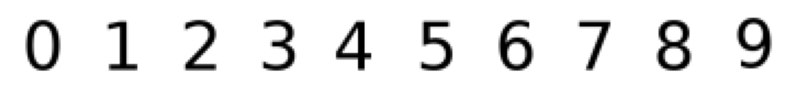

In [4]:
fig, ax = plt.subplots( 1, len(data_train), figsize=(min(11,len(data_train)),5))
for c in range(len(data_train)): 
    ax[c].axis('off')
    ax[c].imshow(data_train[c],cmap='gray') #,cmap='GnBu')

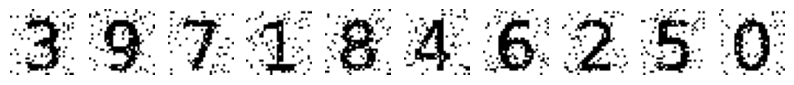

In [5]:
data_test_ = data_test[rng.permutation(len(data_test))[:len(data_train)]]
fig, ax = plt.subplots( 1, len(data_test_), figsize=(min(11,len(data_test_)),5))
for c in range(len(data_test_)): 
    ax[c].axis('off')
    ax[c].imshow(data_test_[c],cmap='gray')

## формируем датасет

In [6]:
n,w,h = data_train.shape
x_train = np.sign( 254.-data_train ).reshape(n,w*h)

n,w,h = data_test.shape
x_test = np.sign( 254.-data_test ).reshape(n,w*h)

display(( x_train.shape, x_test.shape ))

((10, 900), (10, 900))

In [7]:
# data_train
# data_test
# x_train
# x_test

# модель

![hopfield](http://mechanoid.su/content/neural-net-hopfield-associative-memory.html/hopfield.bmp)

In [8]:
class HophieldNet:
    
    def __init__(self):
        self._weight = 0.
        self._bias = 0.
        
    def fit(self,x):
        assert len(x)>1
        batch_size, data_size = x.shape
        self._weight = x.T.dot(x)
        self._bias = x.sum(axis=0)
        # обнуляем главную диагональ матрицы весов
        # т.е. удаляем обратную связь нейрона на самого себя 
        self._weight = self._weight *(np.ones([data_size,data_size])-np.eye(data_size,data_size))
        return self
    
    def forward(self,x,max_iter=8):
        o = x
        for n in range(max_iter):
            o_ = o # сохраняем состояние
            o = self._forward_step(o) # переходим в новое состояние
            # если состояние не изменилось то завершаем
            if np.all(o==o_): break
        return n,o        
    
    def _forward_step(self,x):
        return np.sign( x.dot(self._weight) - self._bias )
    

энергия сети

$E = - \left( s\cdot W \right) * s - s*\theta $   

$\cdot$ - матричное умножение  
$*$ - поэлементное умножение   
$s$ - состояние сети   
$W$ - матрица весов   
$\theta$ - вектор сдвигов  

генерируем случайное состояние r

и считаем изменение энергии сети

$\Delta E = E(r) - E(s)$

если $\Delta E_i\leq 0$   
то $s_i:=r_i$  
иначе принимаем $s_i:=r_i$ c вероятностью $p_i$

$$
p(\Delta E,t) = 1-\frac{1}{1+\exp\left(-\frac{\Delta E}{t}\right)}
$$

Text(0, 0.5, 'p')

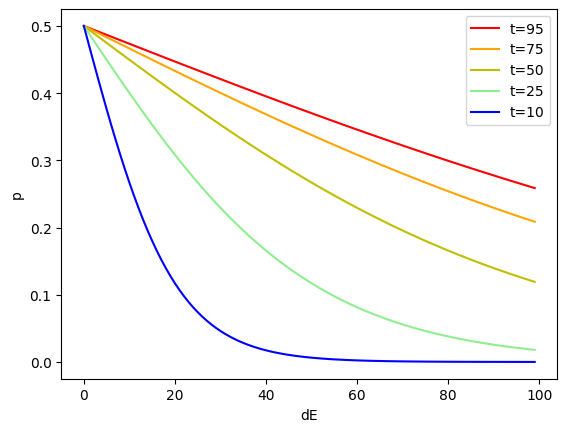

In [9]:
# зависимость вероятности перехода от изменения энергии de
# при фиксированной температуре t 
p = lambda dE,t: 1.-1./(1.+np.exp(-dE/t)) 
de = np.linspace(0,100,100)

t=95; plt.plot(p(de,t),label=f't={t}',c='r')
t=75; plt.plot(p(de,t),label=f't={t}',c='orange')
t=50; plt.plot(p(de,t),label=f't={t}',c='y')
t=25; plt.plot(p(de,t),label=f't={t}',c='lightgreen')
t=10; plt.plot(p(de,t),label=f't={t}',c='b')
plt.legend()
plt.xlabel('dE')
plt.ylabel('p')

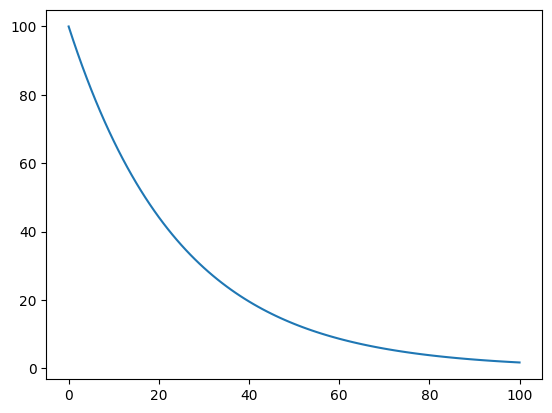

In [10]:
# изменение "температуры" сети
t = [100]
for _ in range(100): t.append( t[-1]*.96  )
plt.plot(range(101),t)

---

In [11]:
class BoltzmanNet(HophieldNet):

    def __init__(self):
        super().__init__()
        self._t = 100. # "температура" модели 

    def forward(self,x,max_iter=64):
        self._t = 100. # начальная "температура"    
        return super().forward(x,max_iter)
    
    def _forward_step(self,x):
        o = self._change_state(x.copy())
        self._t *= .96 # понизить температуру
        return o
            
    def _change_state(self,state):
        random_state = self._random_state(state.shape) # случайное состояние
        dE = self._energy(random_state) - self._energy(state) # изменение энергии нейронов
        
        # если изменение энергии меньше нуля 
        mask_0 = dE<0 # условие: изменение энергии нейрона
        # то принимаем новое состояние нейрона
        state[mask_0] = random_state[mask_0]

        # если изменение энергии больше нуля 
        # то принимаем новое состояние нейрона с вероятностью p
        p = self._prob(dE)
        mask_1 = rng.rand(*state.shape) < p # нейроны, для которых будем менять состояние
        mask_1 = np.logical_and(np.logical_not(mask_0),mask_1)
        state[mask_1] = random_state[mask_1]
        
        return state
                
    def _random_state(self,shape):
        return rng.randint(0,2,shape)*2-1 # случайное состояние
    
    def _energy(self,x): 
        return -x.dot(self._weight)*x - x*self._bias
    
    def _prob(self,dE):
        return 1.-1./(1.+np.exp(-dE/self._t)) # вероятности переходов в новое состояние
        

In [12]:
# from time import time
# # инициализация генератора псевдослучайных чисел
# rng.seed(seed= int(((time()%1)/(time()//1))*1e11) )

# загружаем память модели

In [13]:
model = BoltzmanNet().fit(x_train)

# тестируем

In [14]:
from tqdm.auto import tqdm

In [15]:
o = [
        model.forward(x_test[[i],:])
        for i in tqdm(range(len(x_test)))
    ]

n = [ n for n,_ in o ]
o = np.vstack([ x for _,x in o ])
display(o.shape)

  0%|          | 0/10 [00:00<?, ?it/s]

(10, 900)

In [16]:
display(n)

[10, 11, 8, 7, 10, 9, 22, 21, 9, 9]

In [17]:
def plot_images_pair(data0,data1,ncols=7):
    assert data0.shape == data1.shape
    
    ncols_ = ncols*2
    nrows = int(np.ceil(len(data0)/ncols))
    
    figsize=(ncols_,nrows)
    fig, ax = plt.subplots( nrows, ncols_, figsize=figsize)
    
    for r in range(nrows): 
        for c in range(0,ncols_,2): 
            ax[r,c].axis('off')
            ax[r,c+1].axis('off')
            
            n = r*ncols+c//2
            if ( n+1 > len(data0) ): continue
                
            ax[r,c].imshow(data0[n],cmap='gray')
            ax[r,c+1].imshow(data1[n],cmap='copper') # summer winter

(10, 30, 30)

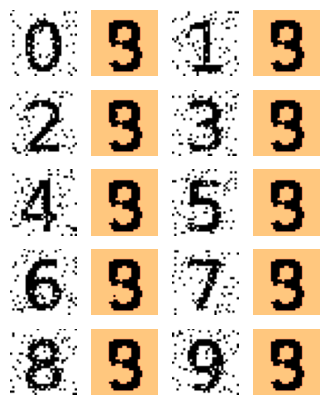

In [18]:
(w,h),n = data_test[0].shape,len(data_test)
o_ = ((1-o.reshape(n,w,h))*127).astype(np.uint8)
display(o_.shape)

data_test_ = ((1-x_test.reshape(n,w,h))*127).astype(np.uint8)

plot_images_pair(data_test_,o_,ncols=2)